# Forecast using auto_arima at scale

## Motivation

The `auto_arima` model is widely used to forecast time series in production and as a benchmark. However, the python implementation (`pmdarima`) is so slow that prevent data scientist practioners from quickly iterating and deploying `auto_arima` in production for a large number of time series. In this notebook we present Nixtla's `auto_arima` based on the R implementation (developed by Rob Hyndman) and optimized using `numba`.

## Example

### Libraries

In [1]:
#!pip install statsforecast

In [2]:
import random
import time
from multiprocessing import cpu_count, Pool # for prophet
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from statsforecast.core import StatsForecast
from statsforecast.models import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import ParameterGrid

Importing plotly failed. Interactive plots will not work.


#### Useful functions

The `plot_grid` function defined below will be useful to plot different time series, and different models' forecasts.

In [3]:
def plot_grid(df_train, df_test=None, plot_random=True):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for model in df_test.drop(['unique_id', 'ds'], axis=1).columns:
                if all(np.isnan(test_uid[model])):
                    continue
                axes[idx, idy].plot(test_uid['ds'], test_uid[model], label=model)

        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [4]:
def plot_autocorrelation_grid(df_train):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"

    unique_ids = random.sample(list(unique_ids), k=8)

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        plot_acf(train_uid['y'].values, ax=axes[idx, idy], 
                 title=f'ACF M4 Hourly {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Autocorrelation')
    fig.subplots_adjust(hspace=0.5)
    plt.show()

### Data

For testing purporses, we will use the Hourly dataset from the M4 competition.

In [5]:
train = pd.read_csv('M4-Hourly.csv')
test = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [6]:
n_series = 16
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

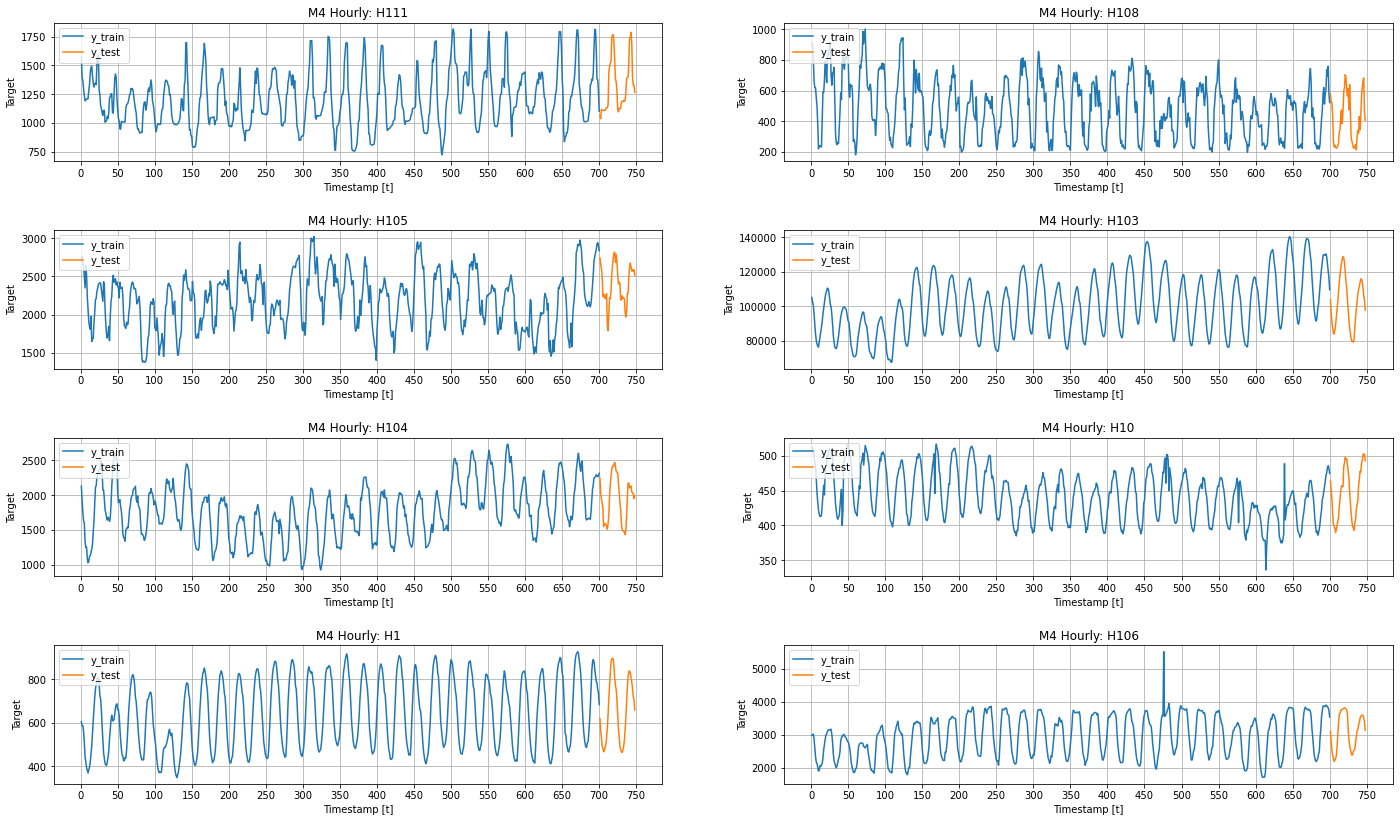

In [7]:
plot_grid(train, test)

Would nn autorregresive model be the right choice for our data? There is no doubt that we observe seasonal periods. The autocorrelation function (`acf`) can help us to answer the question. Intuitively, we have to observe a decreasing correlation to opt for an AR model. 

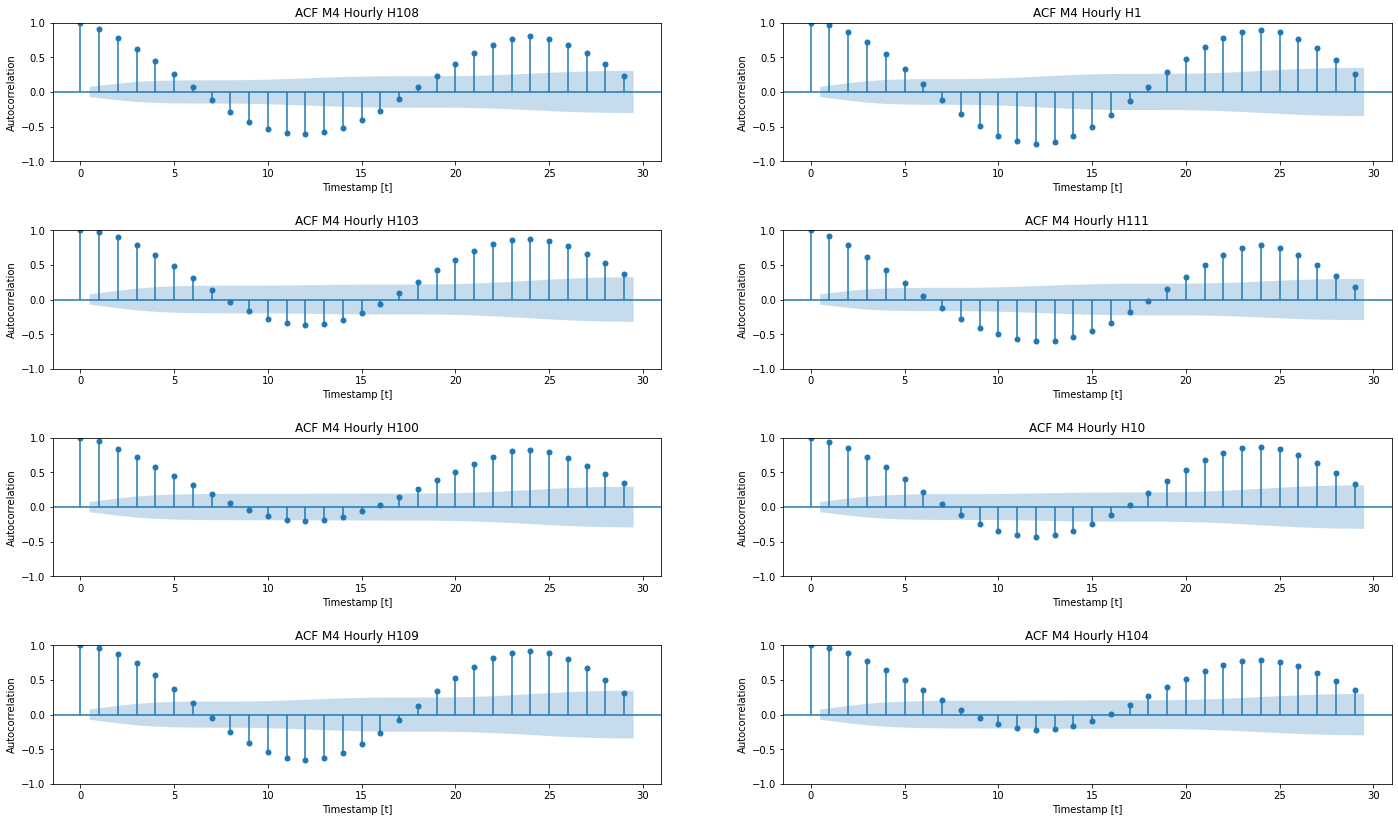

In [8]:
plot_autocorrelation_grid(train)

Thus, we observe a high autocorrelation for previous lags and also for the seasonal lags. Therefore, we will let `auto_arima` to handle our data.

### Training and forecasting

`StatsForecast` receives a list of models to fit each time series. If you want to provide an extra argument to the model's function you have to pass a tuple of the form `(model, arg1, arg2)`. Since we are dealing with Hourly data, it would be benefitial to use 24 as seasonality.

In [9]:
?auto_arima

Signature:
auto_arima(
    y: numpy.ndarray,
    h: int,
    season_length: int = 1,
    approximation: bool = False,
) -> numpy.ndarray
Docstring: <no docstring>
File:      ~/statsforecast/statsforecast/models.py
Type:      function


As we see, we can pass `season_length` to `auto_arima`, so the definition of our models would be,

In [10]:
models = [(auto_arima, 24)]

In [11]:
fcst = StatsForecast(train.set_index('unique_id'), models=models, freq='H', 
                     n_jobs=min(cpu_count(), n_series))

In [12]:
init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(48)
end = time.time()

time_nixtla = end - init
time_nixtla

2022-02-17 03:46:43 statsforecast.core INFO: Computing forecasts
2022-02-17 03:47:55 statsforecast.core INFO: Computed forecasts for auto_arima_season_length-24.


72.4041793346405

In [13]:
forecasts.head()

,ds,auto_arima_season_length-24
unique_id,,
H1,701,653.629456
H1,702,582.658447
H1,703,533.146362
H1,704,500.925110
H1,705,476.933350


In [14]:
forecasts = forecasts.reset_index()

In [15]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

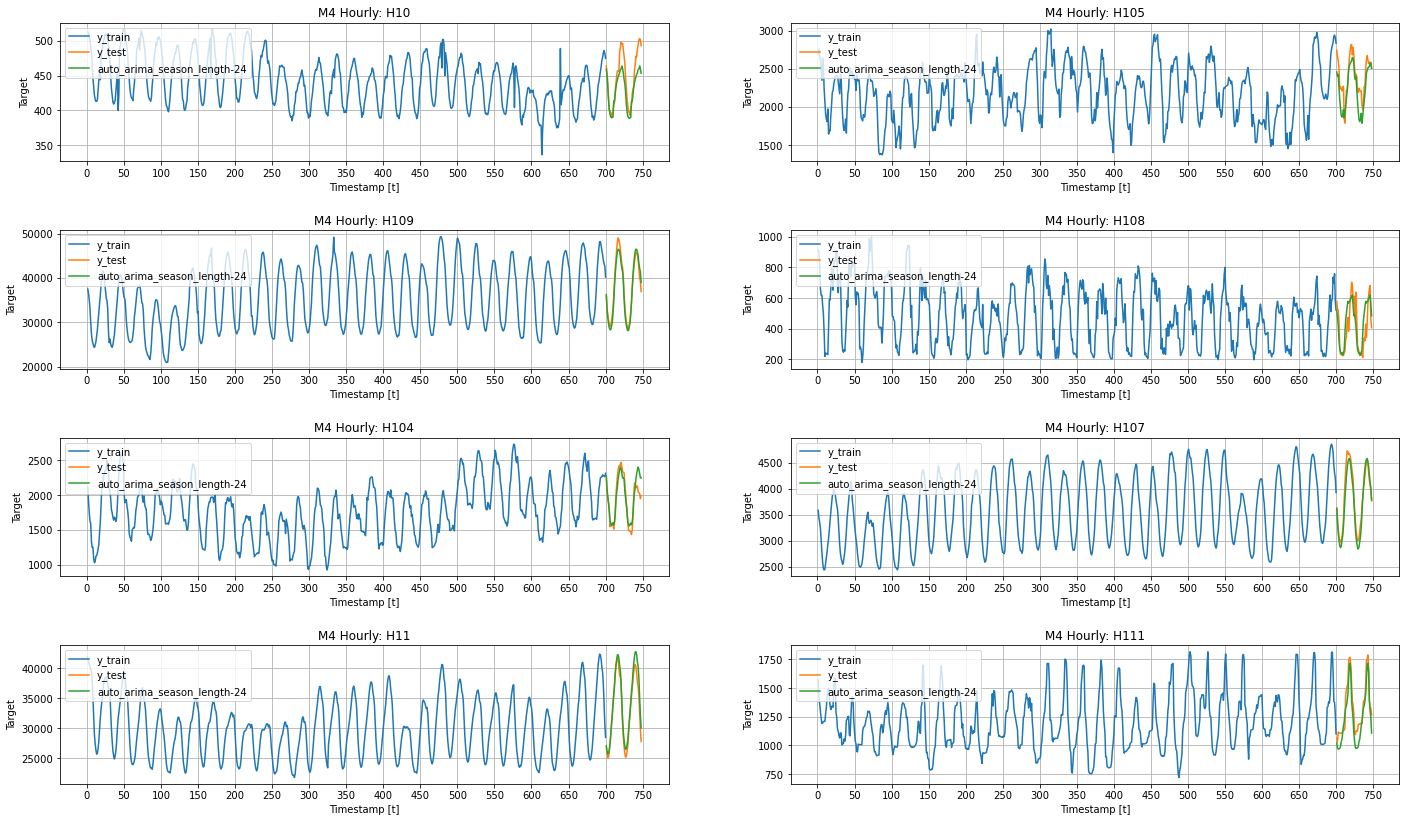

In [16]:
plot_grid(train, test)

## Alternatives

### pmdarima

You can use the `StatsForecast` class to parallelize your own models. In this section we will use it to run the `auto_arima` model from `pmdarima`.

In [17]:
from pmdarima import auto_arima as auto_arima_p

In [18]:
def auto_arima_pmdarima(y, h, season_length):
    mod = auto_arima_p(y, m=season_length, 
                       with_intercept=False) #ensure comparability with Nixtla's implementation
    return mod.predict(h)

In [19]:
n_series_pmdarima = 2

In [20]:
fcst = StatsForecast(
    train.query('unique_id in ["H1", "H10"]').set_index('unique_id'), 
    models=[(auto_arima_pmdarima, 24)],
    freq='H',
    n_jobs=min(n_series_pmdarima, cpu_count())
)

In [21]:
init = time.time()
forecast_pmdarima = fcst.forecast(48)
end = time.time()

time_pmdarima = end - init
time_pmdarima

2022-02-17 03:47:56 statsforecast.core INFO: Computing forecasts
2022-02-17 03:53:46 statsforecast.core INFO: Computed forecasts for auto_arima_pmdarima_season_length-24.


350.12543296813965

In [22]:
forecast_pmdarima.head()

,ds,auto_arima_pmdarima_season_length-24
unique_id,,
H1,701,627.389404
H1,702,570.088684
H1,703,541.430603
H1,704,515.868286
H1,705,502.232361


In [23]:
forecast_pmdarima = forecast_pmdarima.reset_index()

In [24]:
test = test.merge(forecast_pmdarima, how='left', on=['unique_id', 'ds'])

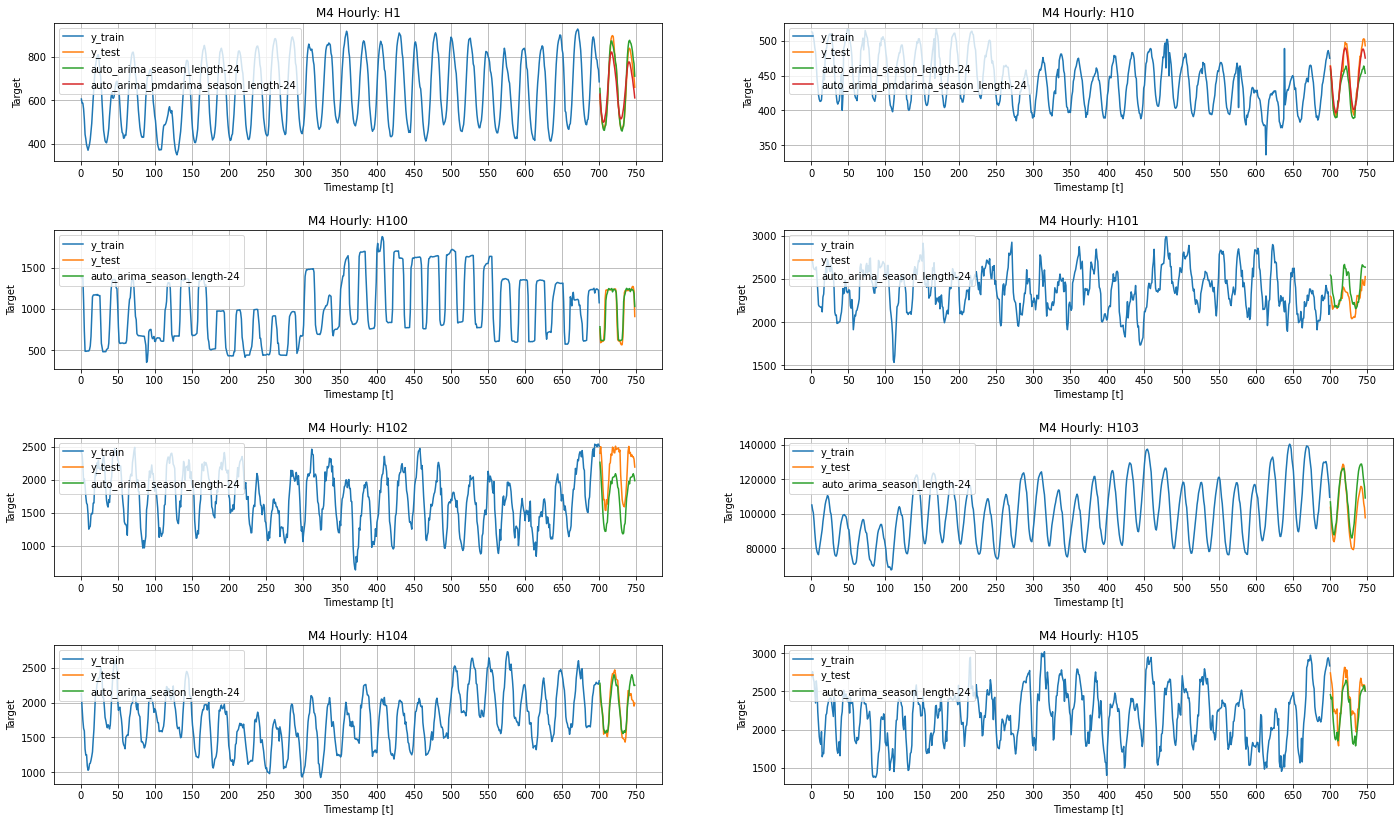

In [25]:
plot_grid(train, test, plot_random=False)

### Prophet 

`Prophet` is designed to receive a pandas dataframe, so we cannot use `StatForecast`. Therefore, we need to parallize from scratch.

In [26]:
params_grid = {'seasonality_mode': ['multiplicative','additive'],
               'growth': ['linear', 'flat'], 
               'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5], 
               'n_changepoints': [5, 10, 15, 20]} 
grid = ParameterGrid(params_grid)

In [27]:
def fit_and_predict(index, ts):
    df = ts.drop('unique_id', 1)
    max_ds = df['ds'].max()
    df['ds'] = pd.date_range(start='1970-01-01', periods=df.shape[0], freq='H')
    df_val = df.tail(48) 
    df_train = df.drop(df_val.index) 
    y_val = df_val['y'].values
    
    if len(df_train) >= 48:
        val_results = {'losses': [], 'params': []}

        for params in grid:
            model = Prophet(seasonality_mode=params['seasonality_mode'],
                            growth=params['growth'],
                            weekly_seasonality=True,
                            daily_seasonality=True,
                            yearly_seasonality=True,
                            n_changepoints=params['n_changepoints'],
                            changepoint_prior_scale=params['changepoint_prior_scale'])
            model = model.fit(df_train)
            
            forecast = model.make_future_dataframe(periods=48, 
                                                   include_history=False, 
                                                   freq='H')
            forecast = model.predict(forecast)
            forecast['unique_id'] = index
            forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])
            
            loss = np.mean(abs(y_val - forecast['yhat'].values))
            
            val_results['losses'].append(loss)
            val_results['params'].append(params)

        idx_params = np.argmin(val_results['losses']) 
        params = val_results['params'][idx_params]
    else:
        params = {'seasonality_mode': 'multiplicative',
                  'growth': 'flat',
                  'n_changepoints': 150,
                  'changepoint_prior_scale': 0.5}
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    growth=params['growth'],
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=True,
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'])
    model = model.fit(df)
    
    forecast = model.make_future_dataframe(periods=48, 
                                           include_history=False, 
                                           freq='H')
    forecast = model.predict(forecast)
    forecast.insert(0, 'unique_id', index)
    forecast['ds'] = np.arange(max_ds + 1, max_ds + 48 + 1)
    forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])
    
    return forecast

In [28]:
import logging
logging.getLogger('prophet').setLevel(logging.WARNING) 

In [29]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [30]:
import os

In [31]:
init = time.time()
with suppress_stdout_stderr():
    with Pool(cpu_count()) as pool:
        forecast_prophet = pool.starmap(fit_and_predict, train.groupby('unique_id'))
end = time.time()
forecast_prophet = pd.concat(forecast_prophet).rename(columns={'yhat': 'prophet'})
time_prophet = end - init
time_prophet

/home/ubuntu/miniconda/envs/arima_nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/home/ubuntu/miniconda/envs/arima_nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/home/ubuntu/miniconda/envs/arima_nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/home/ubuntu/miniconda/envs/arima_nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/home/ubuntu/miniconda/envs/arima_nixtla/lib/python3.7/site-packages/ipykernel_launcher.

135.4461829662323

In [32]:
forecast_prophet

,unique_id,ds,prophet
0,H1,701,633.724577
1,H1,702,563.248671
2,H1,703,501.897752
3,H1,704,459.016048
4,H1,705,434.996324
...,...,...,...
43,H112,744,5908.368751
44,H112,745,5911.353445
45,H112,746,5851.301858
46,H112,747,5779.413130


In [33]:
test = test.merge(forecast_prophet, how='left', on=['unique_id', 'ds'])

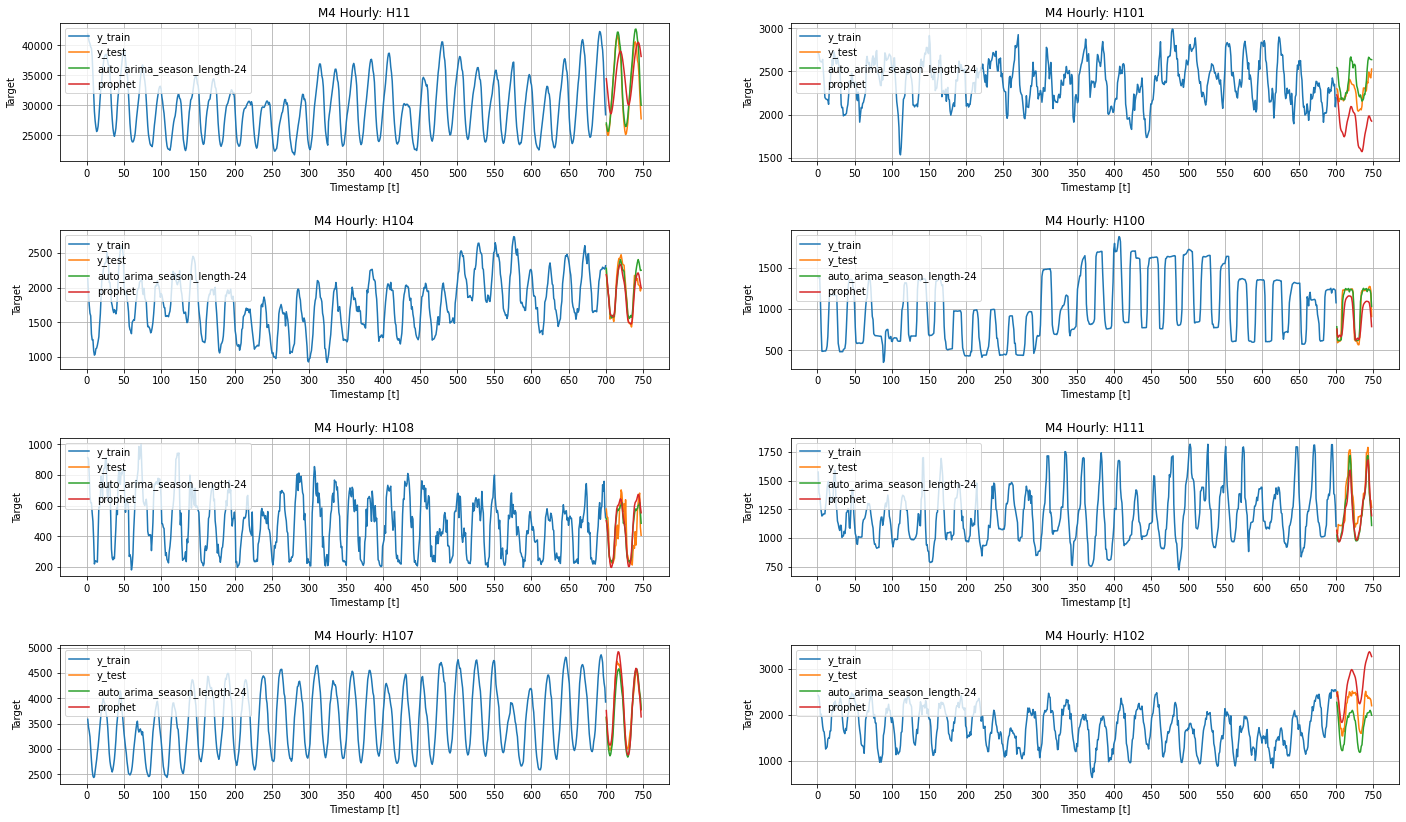

In [34]:
plot_grid(train, test)

### Evaluation

### Time

Since `auto_arima` works with numba is useful to calculate the time for just one time series.

In [35]:
fcst = StatsForecast(train.query('unique_id == "H1"').set_index('unique_id'), 
                     models=models, freq='H', 
                     n_jobs=1)

In [36]:
init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(48)
end = time.time()

time_nixtla_1 = end - init
time_nixtla_1 

2022-02-17 03:56:04 statsforecast.core INFO: Computing forecasts
2022-02-17 03:56:58 statsforecast.core INFO: Computed forecasts for auto_arima_season_length-24.


53.94945979118347

In [37]:
times = pd.DataFrame({'n_series': np.arange(1, 414 + 1)})
times['pmdarima'] = time_pmdarima * times['n_series'] / n_series_pmdarima
times['prophet'] = time_prophet * times['n_series'] / n_series
times['auto_arima_nixtla'] = time_nixtla_1 + times['n_series'] * (time_nixtla - time_nixtla_1) / n_series
times = times.set_index('n_series')

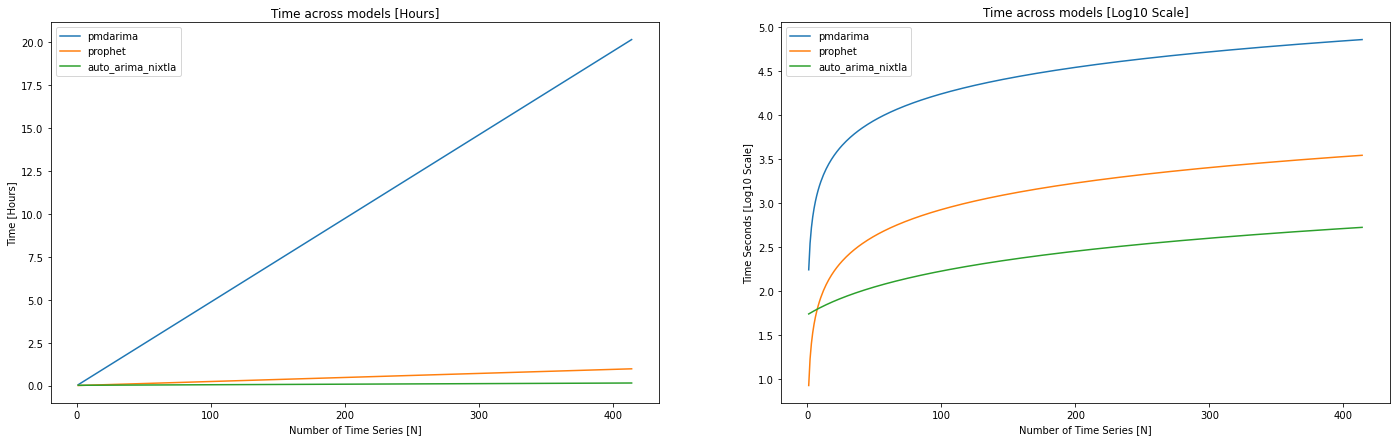

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (24, 7))
(times/3600).plot(ax=axes[0])
np.log10(times).plot(ax=axes[1])
axes[0].set_title('Time across models [Hours]')
axes[1].set_title('Time across models [Log10 Scale]')
axes[0].set_ylabel('Time [Hours]')
axes[1].set_ylabel('Time Seconds [Log10 Scale]')
for ax in axes:
    ax.set_xlabel('Number of Time Series [N]')

### Performance

#### pmdarima (only two time series)

In [39]:
name_models = test.drop(['unique_id', 'ds', 'y_test'], 1).columns.tolist()

/home/ubuntu/miniconda/envs/arima_nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [40]:
test_pmdarima = test.query('unique_id in ["H1", "H10"]')
eval_pmdarima = []
for model in name_models:
    mae = np.mean(abs(test_pmdarima[model] - test_pmdarima['y_test']))
    eval_pmdarima.append({'model': model, 'mae': mae})
pd.DataFrame(eval_pmdarima).sort_values('mae')

,model,mae
0,auto_arima_season_length-24,19.311909
1,auto_arima_pmdarima_season_length-24,26.331168
2,prophet,40.000309


#### Prophet

In [ ]:
eval_prophet = []
for model in name_models:
    if 'pmdarima' in model:
        continue
    mae = np.mean(abs(test[model] - test['y_test']))
    eval_prophet.append({'model': model, 'mae': mae})
pd.DataFrame(eval_prophet).sort_values('mae')

,model,mae
0,auto_arima_season_length-24,741.717361
1,prophet,1032.922064
